# Single-cell RNA-seq Preprocessing Workflow

**Dataset:** NSCLC (Non-Small Cell Lung Cancer) - P1_T1 sample

**Goal:** Process raw 10X Chromium data through standard Seurat pipeline for downstream analysis

Reference: https://satijalab.org/seurat/articles/pbmc3k_tutorial 

## Load libraries

In [1]:
library(tidyverse)
library(Seurat)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




## Load the single-cell data

**Objective:**
- Read 10X Chromium output files (matrix, barcodes, features)
- Create Seurat object with initial QC filters (min.cells = 3, min.features = 200)
- Input: Gene × Cell count matrix

In [3]:
# Load 10X data with custom file prefix
data_dir <- "../data/raw_counts/P1_T1"

# Read the matrix files with prefix
mtx <- ReadMtx(
  mtx = file.path(data_dir, "P1_T1-matrix.mtx.gz"),
  cells = file.path(data_dir, "P1_T1-barcodes.tsv.gz"),
  features = file.path(data_dir, "P1_T1-features.tsv.gz"),
  feature.column = 2
)

# Create Seurat object
seurat_obj <- CreateSeuratObject(counts = mtx, project = "P1_T1", min.cells = 3, min.features = 200)

# Display basic information
seurat_obj

An object of class Seurat 
15044 features across 2140 samples within 1 assay 
Active assay: RNA (15044 features, 0 variable features)
 1 layer present: counts

In [5]:
seurat_obj@assays$RNA$counts[1:5, 1:5]  # Show a subset of the count matrix

5 x 5 sparse Matrix of class "dgCMatrix"
           AAACCTGCACTCGACG-1 AAACCTGTCGGTCCGA-1 AAACGGGAGCCTATGT-1
AL627309.1                  .                  .                  .
AL669831.5                  .                  .                  .
LINC00115                   .                  .                  .
FAM41C                      .                  .                  .
NOC2L                       .                  .                  .
           AAACGGGAGCTGGAAC-1 AAACGGGAGGCGACAT-1
AL627309.1                  .                  .
AL669831.5                  .                  .
LINC00115                   .                  .
FAM41C                      .                  1
NOC2L                       .                  .

## QC and filtering

**Why?**
- Remove low-quality cells (empty droplets, dying cells, doublets)
- Low-quality data introduces noise in downstream analysis

**Metrics:**
- `nFeature_RNA`: number of genes detected per cell
- `nCount_RNA`: total RNA molecules per cell  
- `percent.mt`: mitochondrial gene percentage (high = dying cells)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in SeuratObj

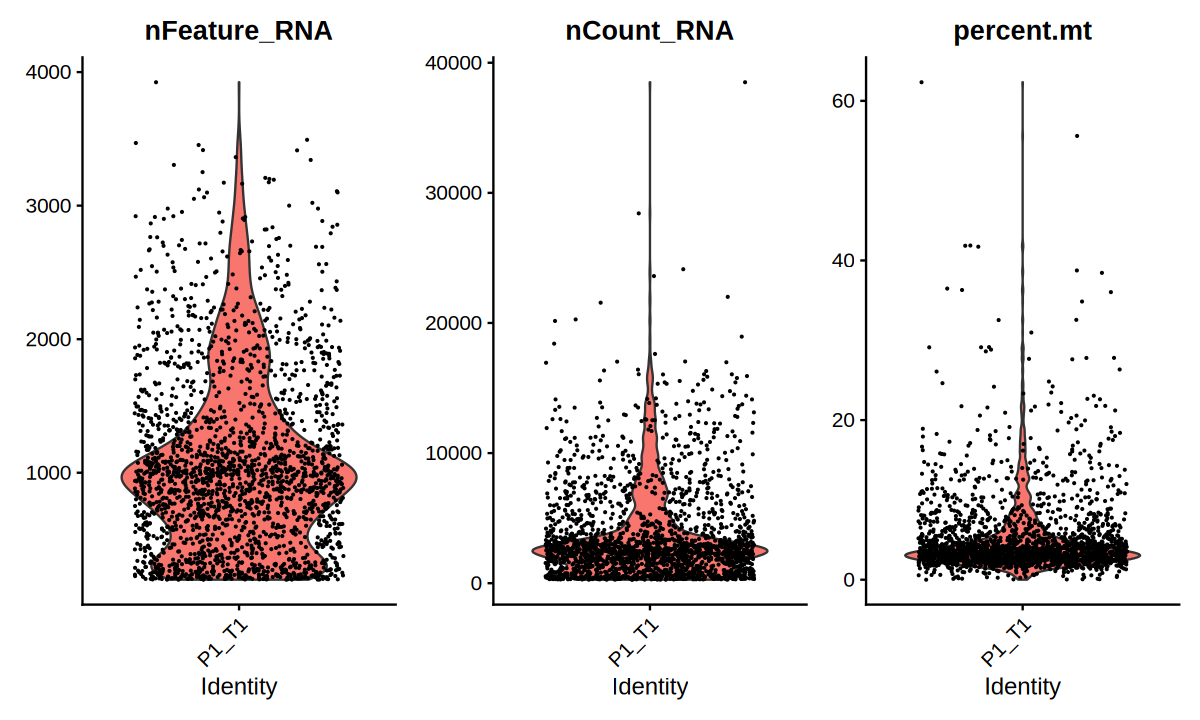

In [6]:
# Calculate mitochondrial QC metrics
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")

# Visualize QC metrics
VlnPlot(seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

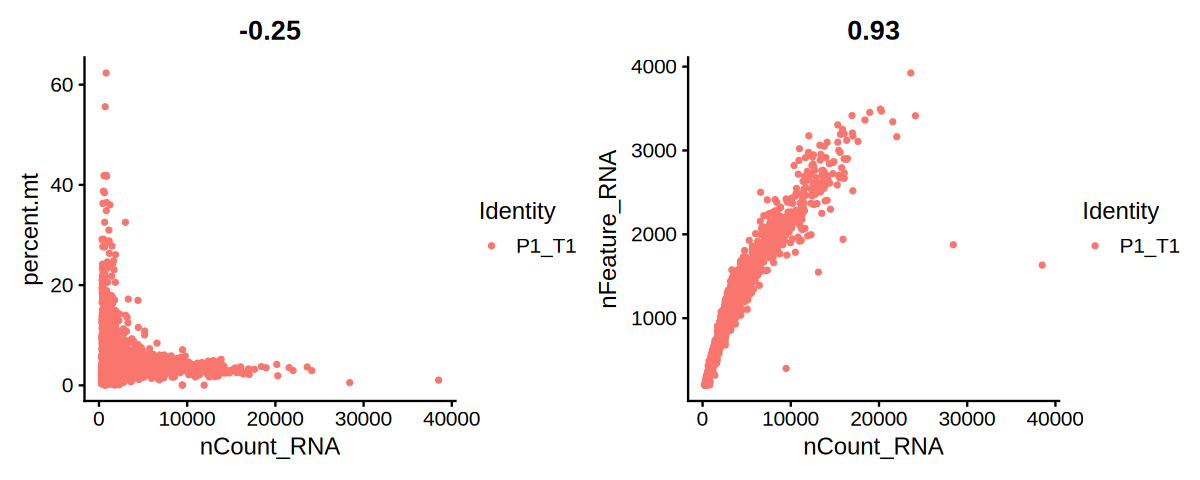

In [7]:
options(repr.plot.width = 10, repr.plot.height = 4)
# Feature-feature relationships
plot1 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [8]:
# Filter cells based on QC metrics
seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## Normalizing the data

**Why?**
- Account for sequencing depth differences between cells
- Makes cells comparable

**Method:** LogNormalize
- Divide gene counts by total counts per cell
- Multiply by scale factor (10,000)
- Log-transform

In [9]:
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



## Identification of highly variable features (Features Selection)

**Why?**
- Focus on genes that vary across cells (informative for cell type differences)
- Reduce dimensionality: ~30,000 genes → 2,000 highly variable genes
- Remove noise from housekeeping genes

**Method:** Variance Stabilizing Transformation (VST)

Finding variable features for layer counts



Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


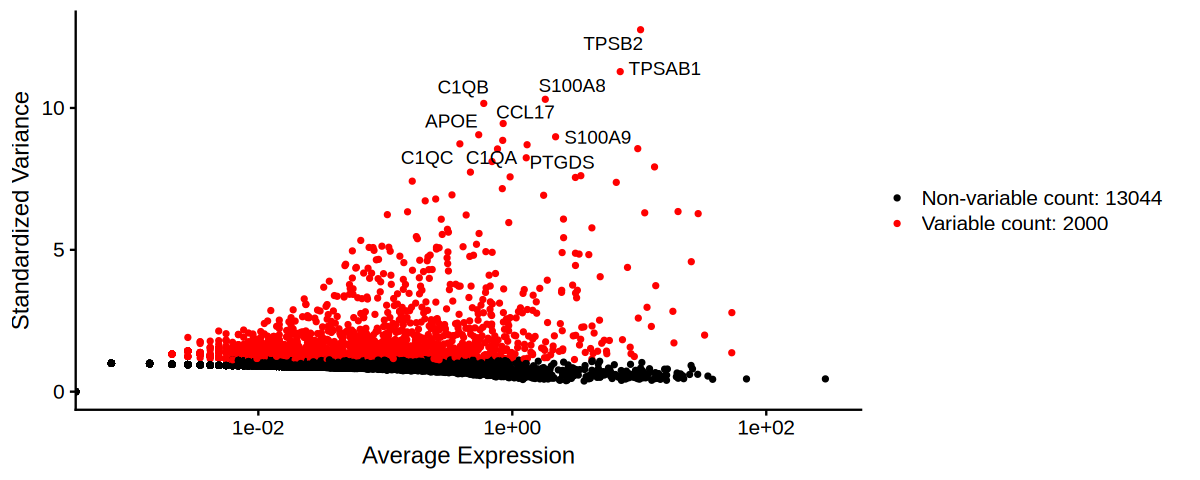

In [10]:
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat_obj), 10)

# Plot variable features with labels
plot1 <- VariableFeaturePlot(seurat_obj)
LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge = 0, ynudge = 0)

## Scaling the data

**Why?**
- Standardize gene expression: zero mean, unit variance
- Prevents highly expressed genes from dominating PCA
- Standard preprocessing for PCA (like in any ML pipeline)

In [11]:
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

Centering and scaling data matrix



## Linear dimensional reduction (PCA)

**Why?**
- Reduce dimensions: 2,000 variable genes → ~50 principal components
- Capture main sources of variation in the data
- Denoise: remove technical noise, keep biological signal

**PCA is essential for:**
- Clustering (next step)
- Visualization
- Computational efficiency

> PCA transforms the 2,000-dimensional space (where each gene is a dimension/feature) into a new 50-dimensional space (where each PC is a dimension), while retaining most of the variance/information. You go from 2,000 features → 50 features (PCs).

In [12]:
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))

PC_ 1 
Positive:  IFI30, AIF1, SPI1, LST1, SERPINA1, FPR1, CLEC7A, CD68, CST3, LILRB2 
	   HCK, NPC2, PLAUR, MS4A7, FCN1, MAFB, CFD, LYZ, CSTA, CTSS 
	   PILRA, FTL, FCGRT, ETS2, FTH1, BCL2A1, FCER1G, CALHM6, GRN, IFITM3 
Negative:  TRBC2, CD69, TRAC, GZMA, TRBC1, CTSW, CD7, IFNG, KLRB1, GZMH 
	   LINC01871, CST7, HOPX, FKBP11, ALOX5AP, PRF1, CD247, IL7R, BATF, GZMB 
	   KLRD1, CD5, NKG7, GNLY, GATA3, FGFBP2, CXCR6, SPON2, GPR171, TBX21 
PC_ 2 
Positive:  FCGR3A, LILRA1, SMIM25, LRRC25, CFD, FCN1, CFP, LILRB2, ABI3, TCF7L2 
	   IFITM2, S100A9, NKG7, TNFRSF1B, MAFB, PRF1, CARD16, PLAC8, C5AR1, CDA 
	   LILRB1, ZNF703, PECAM1, PILRA, LILRA5, CHST2, SLC11A1, FGFBP2, GZMA, CD247 
Negative:  HPGDS, CPA3, MS4A2, MAOB, TPSAB1, LMNA, GATA2, TPSB2, VWA5A, CD9 
	   IL1RL1, HPGD, HDC, CAPG, RGS13, LTC4S, SLC18A2, CALB2, PTGS1, KIT 
	   VIM, AREG, CLU, NTM, ACSL4, STXBP6, AL157895.1, RAB27B, LXN, CPM 
PC_ 3 
Positive:  CPA3, TPSAB1, MS4A2, TPSB2, HPGDS, MAOB, HPGD, GATA2, VWA5A, HDC 
	   RGS13, IL

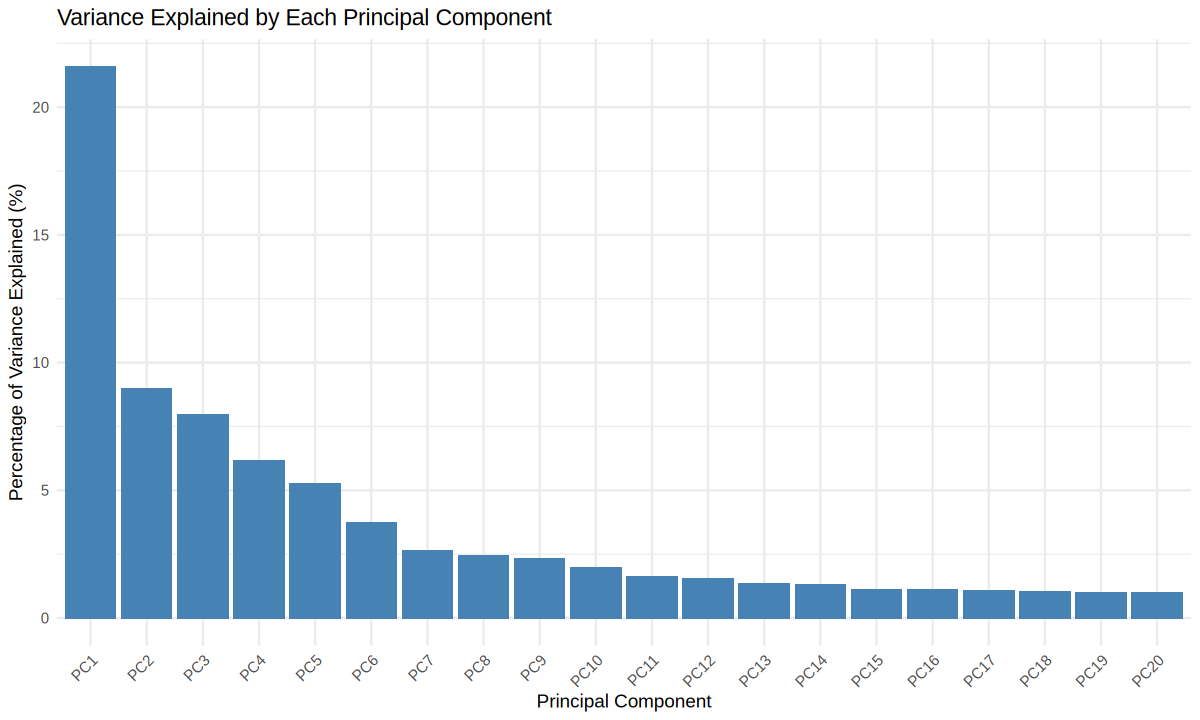

In [17]:
# Bar plot of variance explained by each PC
options(repr.plot.width = 10, repr.plot.height = 6)

# Extract variance explained
pca_var <- seurat_obj@reductions$pca@stdev^2
pca_var_pct <- pca_var / sum(pca_var) * 100

# Create data frame for plotting
pca_df <- data.frame(
  PC = factor(paste0("PC", 1:20), levels = paste0("PC", 1:20)),
  Variance = pca_var_pct[1:20]
)

# Plot first 20 PCs
ggplot(pca_df, aes(x = PC, y = Variance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Variance Explained by Each Principal Component",
       x = "Principal Component",
       y = "Percentage of Variance Explained (%)")

**Interpretation:**

- **PC1** explains the most variance, capturing the main source of variation in the dataset
- **Sharp drop-off:** Variance decreases rapidly after the first few PCs, following a typical scree plot pattern
- **Diminishing returns:** Later PCs contribute progressively less information (mostly noise)
- **Dimensionality selection:** This plot guides how many PCs to use for clustering
    - Focus on top PCs where variance is substantial
    - Typically select PCs before the "elbow" (where variance plateaus)
    - In this case, first ~10-15 PCs capture most biological signal
- **Complements ElbowPlot:** Both methods help determine optimal dimensionality for downstream analysis

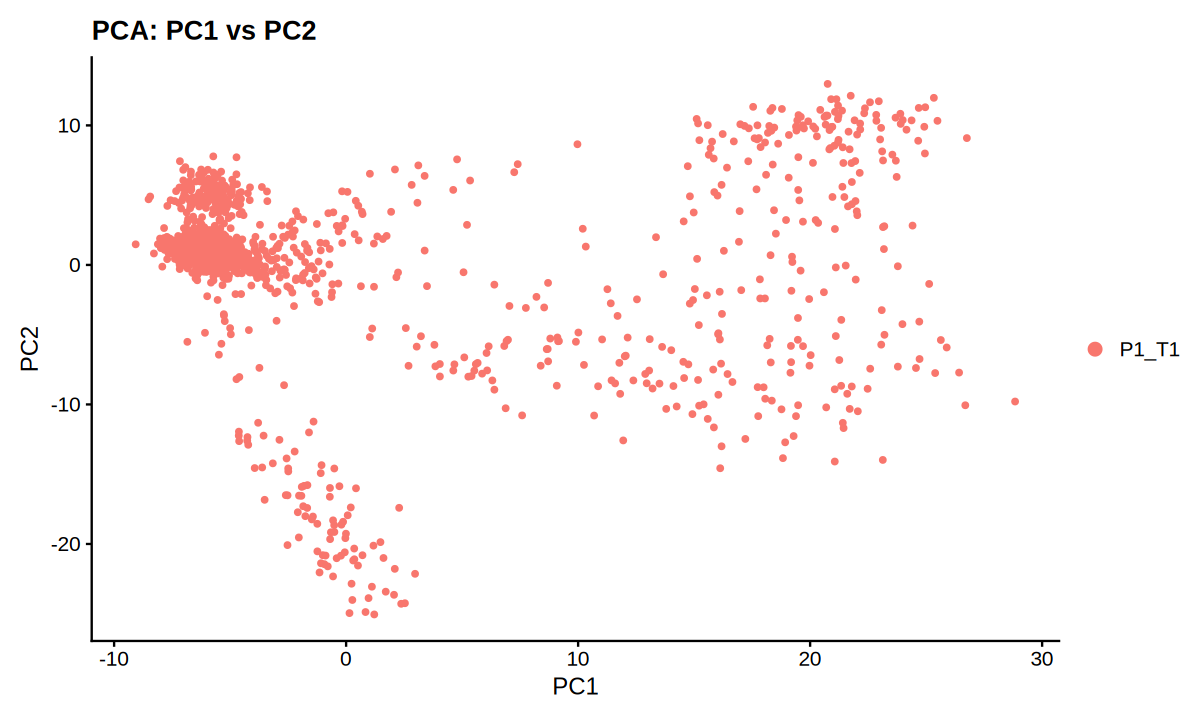

In [14]:
# Visualize PCA: PC1 vs PC2
options(repr.plot.width = 10, repr.plot.height = 6)
DimPlot(seurat_obj, reduction = "pca", dims = c(1, 2)) + 
  ggtitle("PCA: PC1 vs PC2") +
  xlab("PC1") + ylab("PC2")

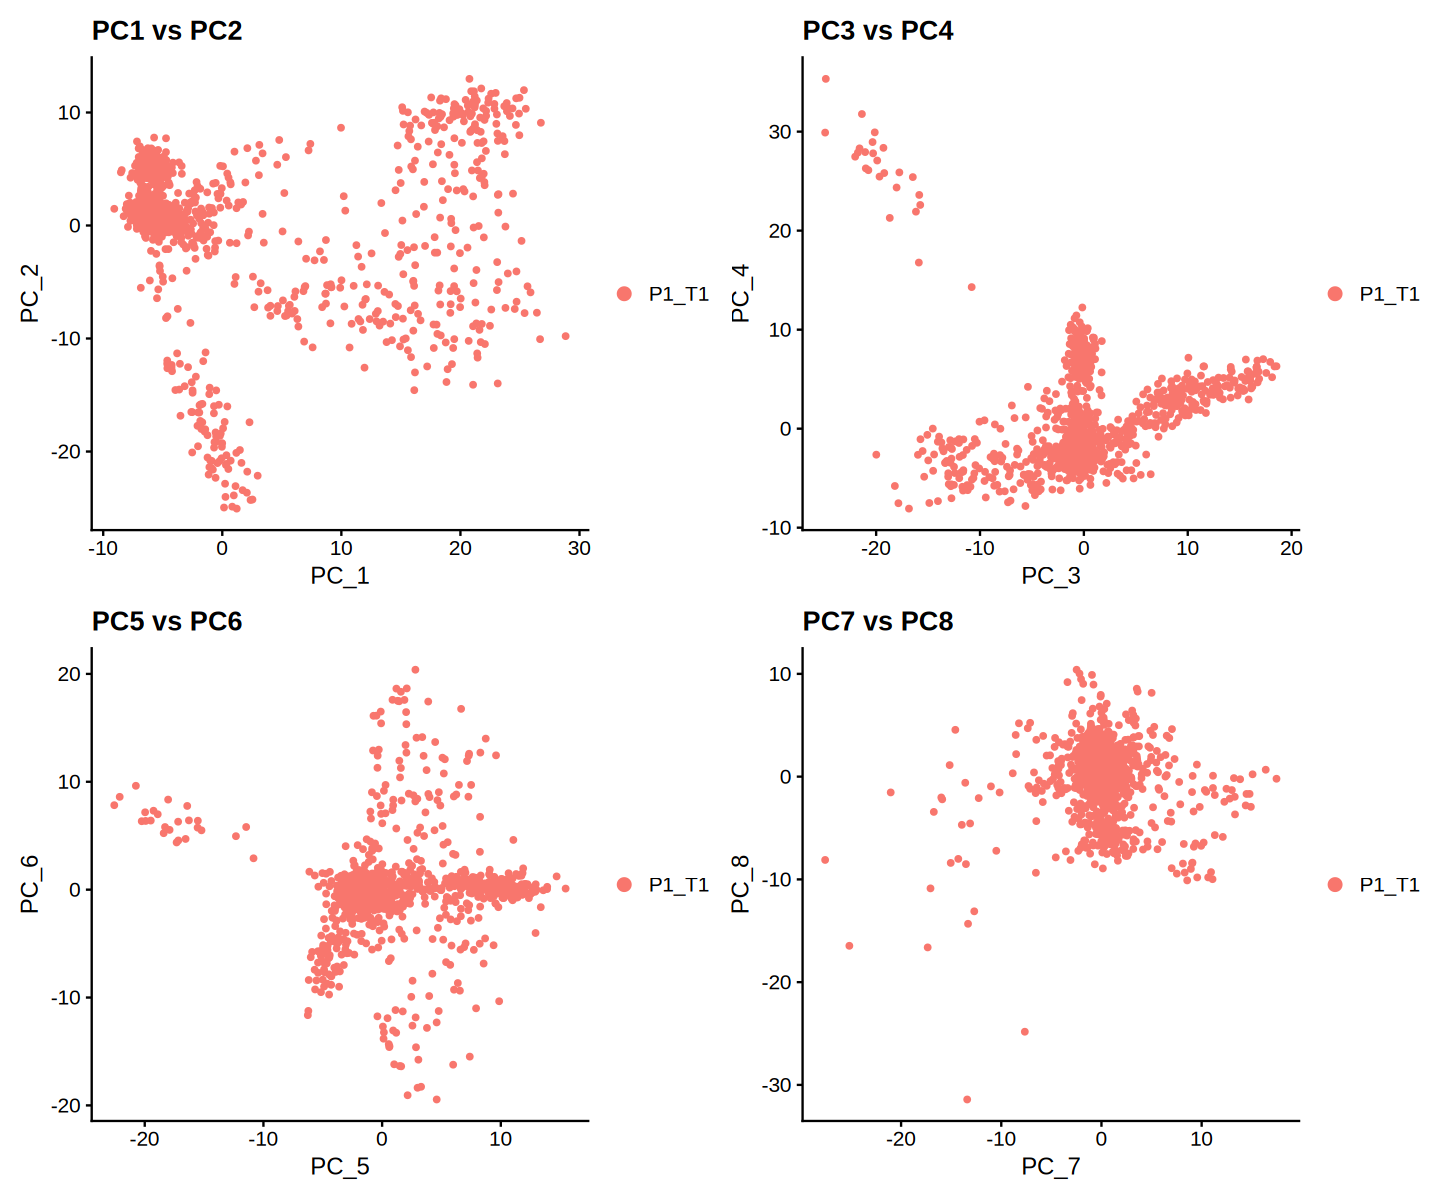

In [15]:
# Visualize other PC combinations
options(repr.plot.width = 12, repr.plot.height = 10)
p1 <- DimPlot(seurat_obj, reduction = "pca", dims = c(1, 2)) + ggtitle("PC1 vs PC2")
p2 <- DimPlot(seurat_obj, reduction = "pca", dims = c(3, 4)) + ggtitle("PC3 vs PC4")
p3 <- DimPlot(seurat_obj, reduction = "pca", dims = c(5, 6)) + ggtitle("PC5 vs PC6")
p4 <- DimPlot(seurat_obj, reduction = "pca", dims = c(7, 8)) + ggtitle("PC7 vs PC8")

(p1 | p2) / (p3 | p4)

In [ ]:
### Examine PCA results

**Understanding PCA loadings:**
- Each PC has positive and negative gene loadings
- Genes with high absolute loadings drive cell separation along that PC
- Positive vs negative loadings represent opposing biological programs

**Example:**

Say PC1 has:

🟦 Positive loadings (high):

- Gene A
- Gene B
- Gene C
(immune-related)

🟥 Negative loadings (high magnitude):

- Gene X
- Gene Y
- Gene Z
(epithelial-related)

**Interpretation:**

- PC1 separates immune-like cells from epithelial-like cells.
- Cells with high PC1 scores express immune genes;
- cells with low PC1 scores express epithelial genes.

So the positive/negative loadings indicate opposite biological programs.

In [18]:
# Examine and visualize PCA results
print(seurat_obj[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  IFI30, AIF1, SPI1, LST1, SERPINA1 
Negative:  TRBC2, CD69, TRAC, GZMA, TRBC1 
PC_ 2 
Positive:  FCGR3A, LILRA1, SMIM25, LRRC25, CFD 
Negative:  HPGDS, CPA3, MS4A2, MAOB, TPSAB1 
PC_ 3 
Positive:  CPA3, TPSAB1, MS4A2, TPSB2, HPGDS 
Negative:  CD74, HLA-DQA1, HLA-DPB1, SERPINF1, HLA-DMB 
PC_ 4 
Positive:  PLAC8, GZMB, LILRA4, SCT, LRRC26 
Negative:  RGCC, TRAC, COTL1, CRIP1, LGALS3 
PC_ 5 
Positive:  FGFBP2, NKG7, PRF1, GNLY, SPON2 
Negative:  LILRA4, SCT, LRRC26, TSPAN13, TPM2 


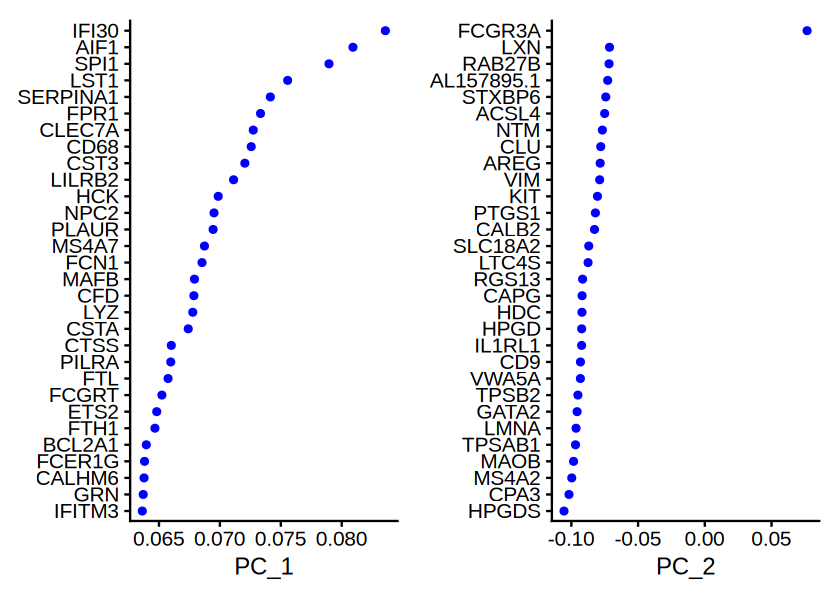

In [20]:
options(repr.plot.width = 7, repr.plot.height = 5)
VizDimLoadings(seurat_obj, dims = 1:2, reduction = "pca")

**VizDimLoadings Interpretation:**

This plot shows the **top genes contributing to PC1 and PC2** (gene loadings):

- **Each bar = one gene** with its loading value (contribution weight to that PC)
- **Positive values (right)**: genes driving cells toward positive PC direction
- **Negative values (left)**: genes driving cells toward negative PC direction

**What it tells us:**

- **Most influential genes**: These genes define what each PC represents biologically
- **PC1 top genes**: Likely separate major cell types (e.g., immune vs epithelial markers)
- **PC2 top genes**: Capture secondary variation (subdividing cell populations)
- **Magnitude matters**: Longer bars = stronger influence on cell positioning

**Use case:**
- Helps interpret what biological differences the PCs capture
- Connects PCA to actual biology (gene expression patterns)
- Validates that PCs are capturing real biological signal, not technical noise

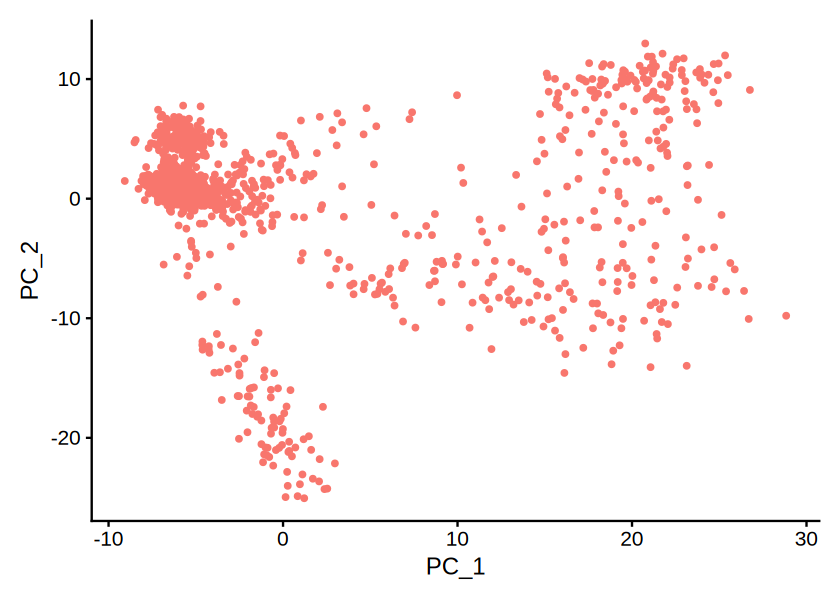

In [21]:
DimPlot(seurat_obj, reduction = "pca") + NoLegend()

### PCA Results interpretation 

**Structure:**

- Clear separation of cell populations along PC1 and PC2
- Multiple distinct clusters visible (suggesting different cell types)
- Some clusters are well-separated, others closer together

**What it reveals:**

- PC1 (x-axis): captures the largest source of variation - likely separates major cell types (e.g., immune vs epithelial cells based on the gene loadings)
- PC2 (y-axis): captures second largest variation - likely further subdivides cell types
- The scattered points = individual cells positioned by their gene expression patterns
  
**Key insight:**

- The clustering structure visible here validates that PCA successfully captured biological variation
- Cells that cluster together in this space likely represent the same cell type
- This 2D projection only shows ~2 dimensions out of 50 PCs, so downstream analysis uses all relevant PCs for clustering

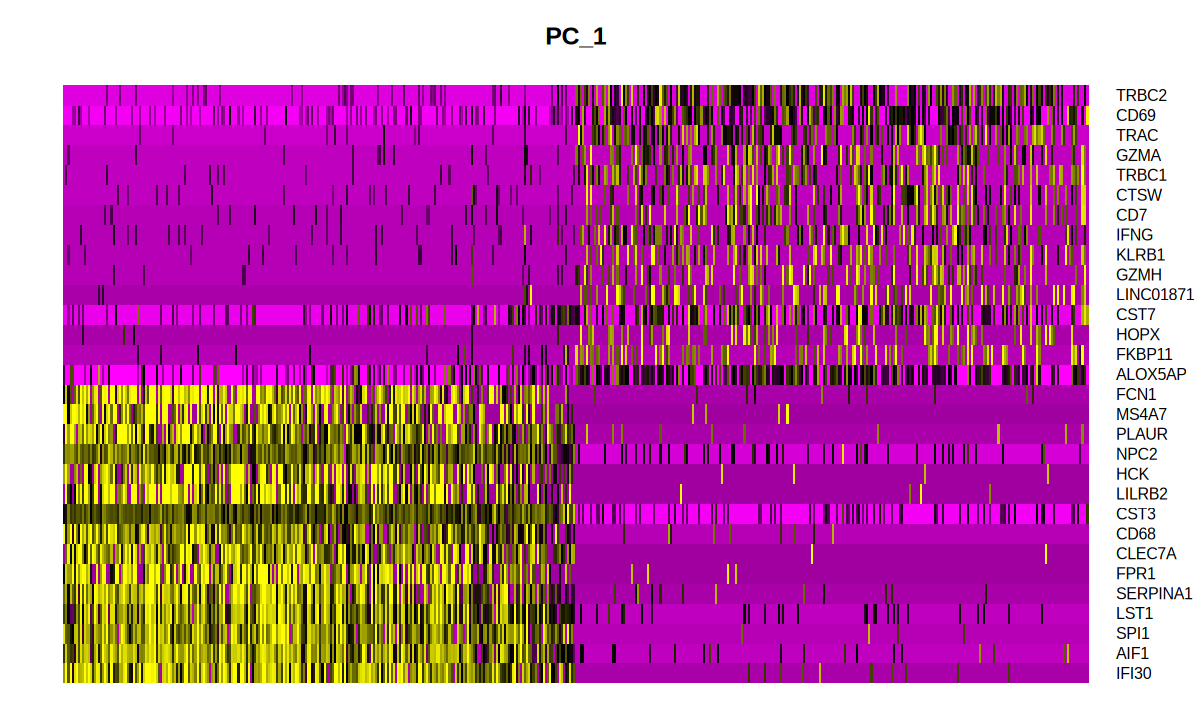

In [18]:
DimHeatmap(seurat_obj, dims = 1, cells = 500, balanced = TRUE)

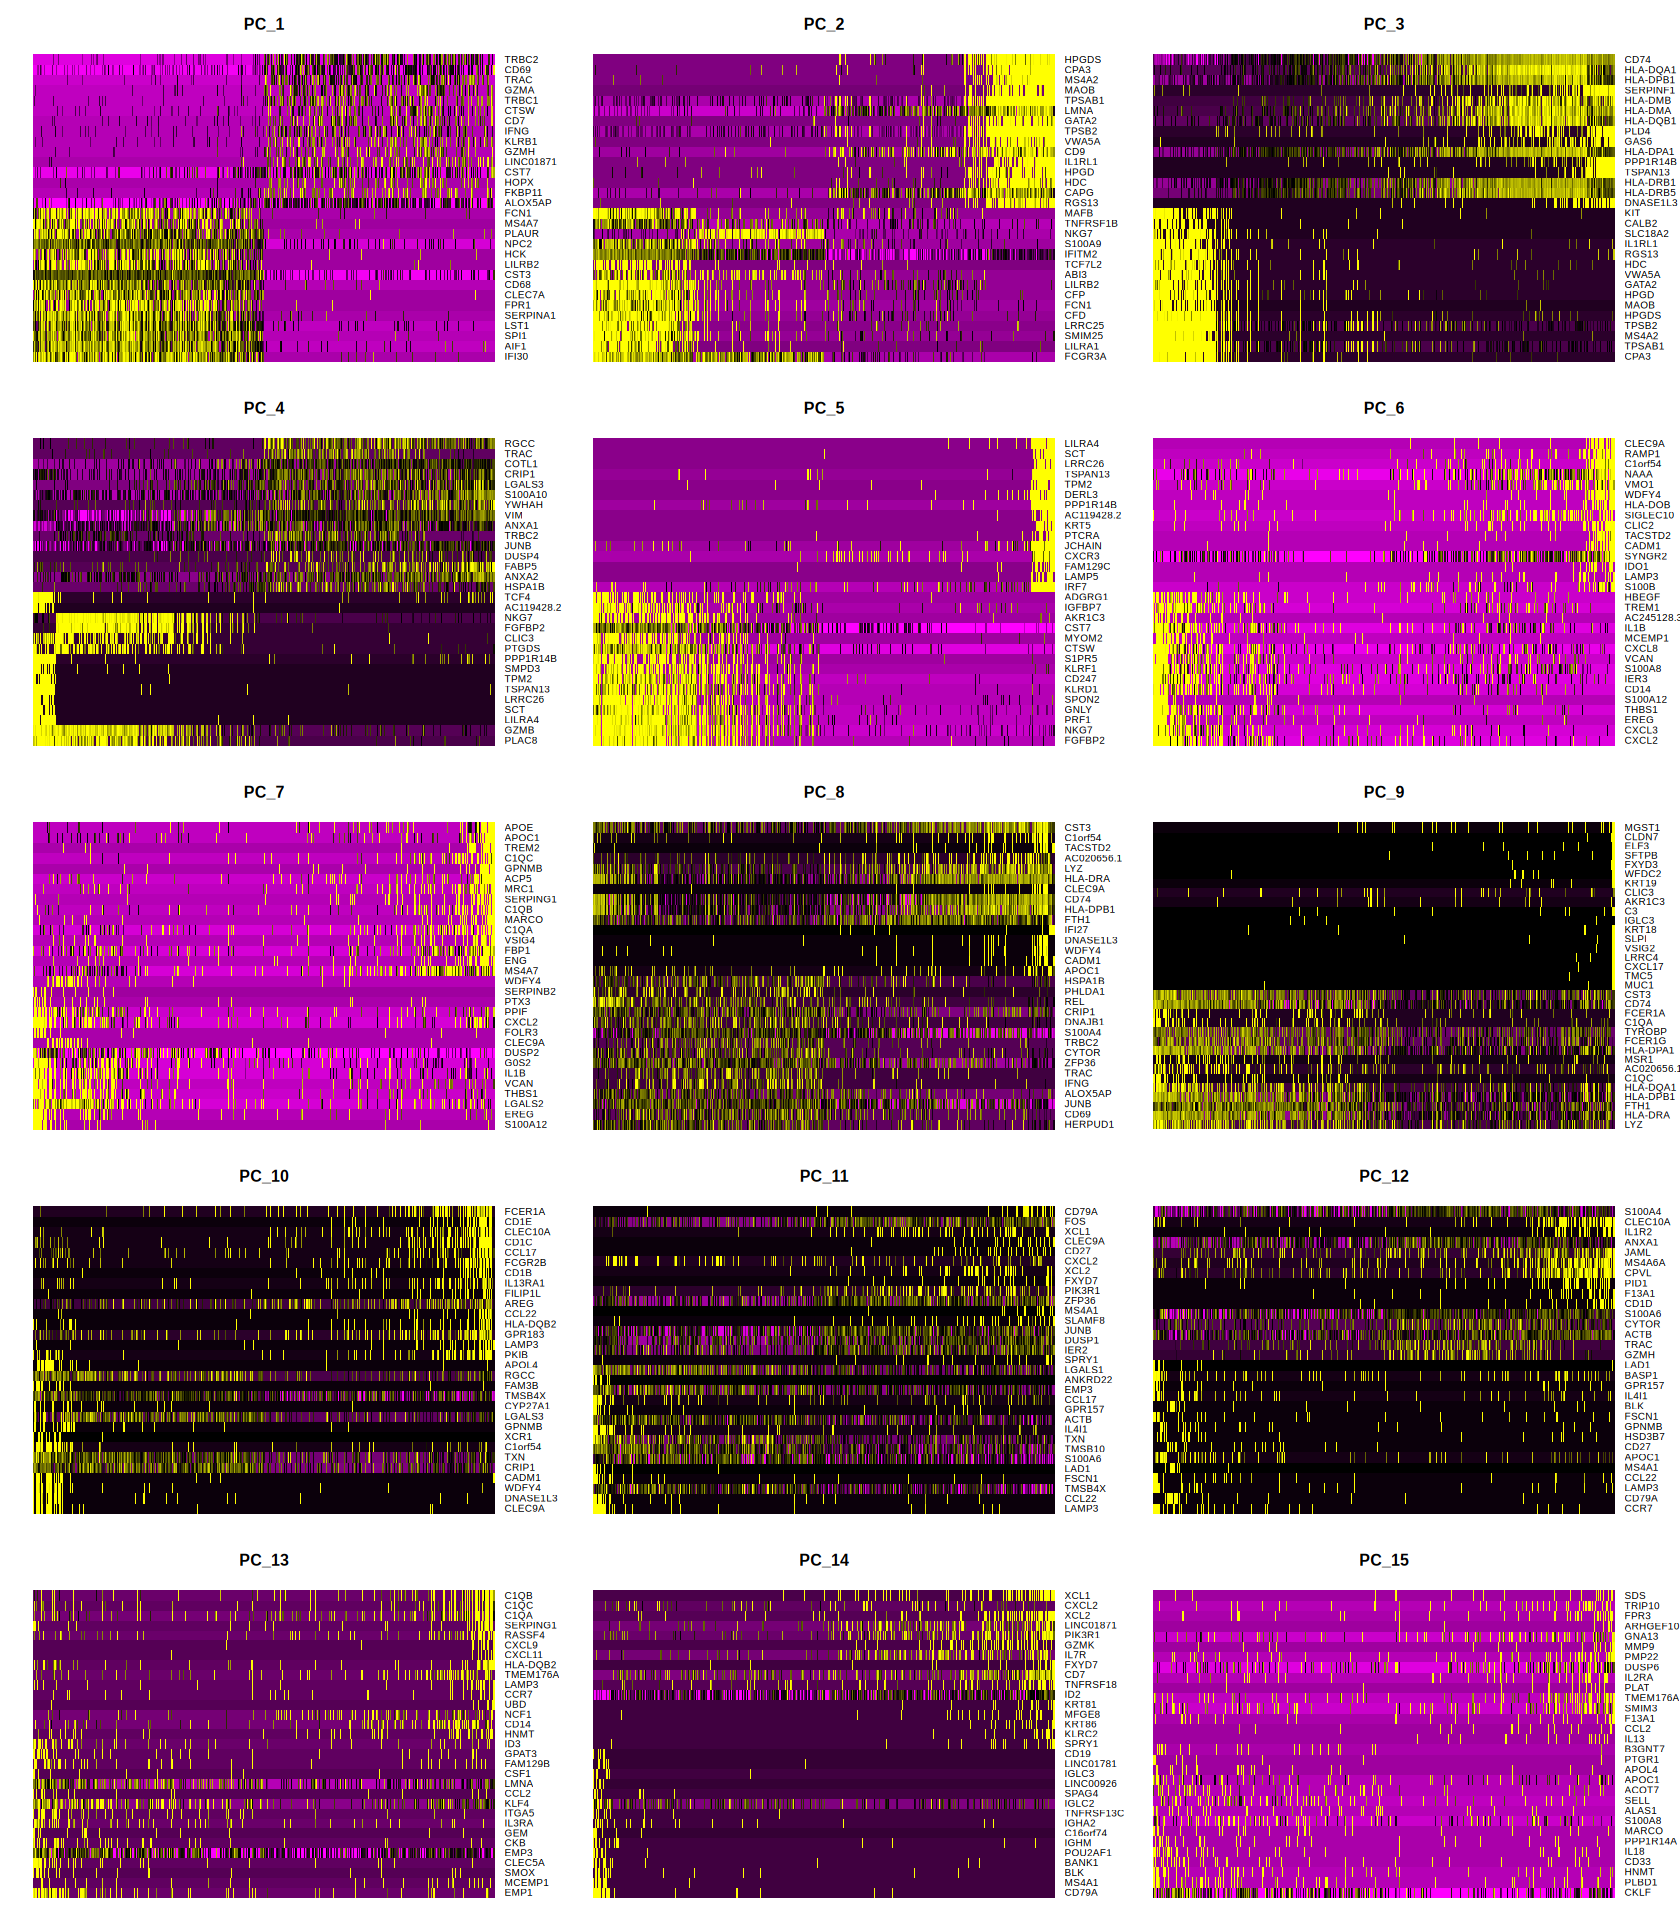

In [19]:
options(repr.plot.width = 14, repr.plot.height = 16)
DimHeatmap(seurat_obj, dims = 1:15, cells = 500, balanced = TRUE)

## Determine the dimensionality of the dataset

**Why?**
- Decide how many PCs to use for clustering
- Balance: enough PCs to capture signal, not too many to include noise

**Methods:**
- **ElbowPlot**: visualize variance explained by each PC (simple, fast)
- **JackStraw**: statistical test (accurate, slow)

In [20]:
# # NOTE: This process can take a long time for big datasets, comment out for expediency. More approximate techniques such as those implemented in ElbowPlot() can be used to reduce computation time
# seurat_obj <- JackStraw(seurat_obj, num.replicate = 100)
# seurat_obj <- ScoreJackStraw(seurat_obj, dims = 1:20)

In [21]:
# JackStrawPlot(seurat_obj, dims = 1:15)

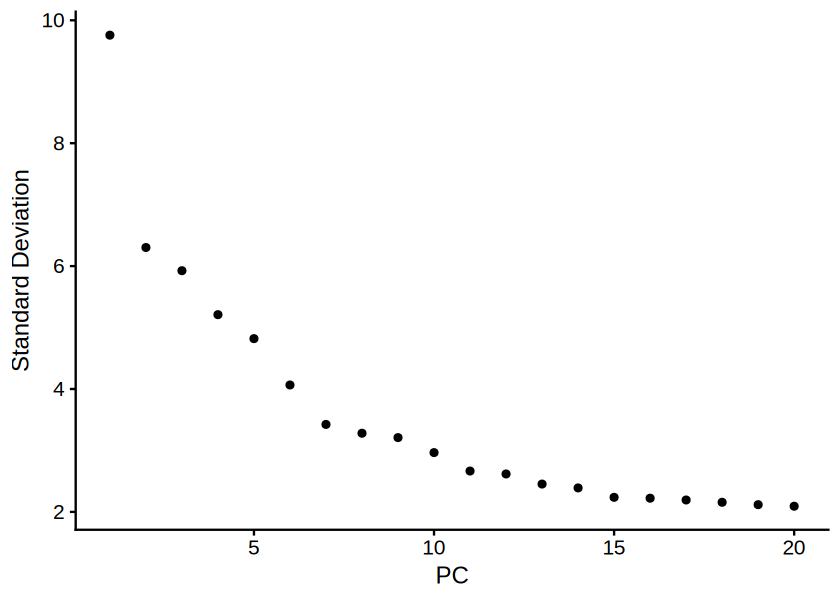

In [22]:
options(repr.plot.width = 7, repr.plot.height = 5)
ElbowPlot(seurat_obj)

## Cluster the cells

**Why clustering?**
- Group cells with similar gene expression patterns → discover cell types/states
- Unsupervised learning: no labels needed
- Reveals biological structure in the data

**Method: Graph-based clustering**
- `FindNeighbors()` - builds kNN graph in PCA space (cells = nodes, edges = similarity)
- `FindClusters()` - community detection using Louvain algorithm
- Better than k-means for complex biological manifolds

**Use the first 10 PCs**

- Based on the ElbowPlot and variance plots earlier, the first ~10 PCs capture most of the biological signal
- Using all 50 PCs would include noise from later PCs (which explain very little variance)
- This is a data-driven decision informed by the dimensionality analysis step

**What it does:**

- Clustering and UMAP both work in this 10-dimensional PCA space
- Not the original 2,000-gene space
- Not just 2D (PC1 vs PC2) visualization

In [23]:
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:10)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5)

Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1436
Number of edges: 47045

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8880
Number of communities: 10
Elapsed time: 0 seconds


**Interpretation**

- Number of nodes: 1436 = 1,436 cells in the dataset
- Number of edges: 47045 = 47,045 connections in the kNN graph (cells connected to their nearest neighbors)
- Maximum modularity: 0.8880 = quality score of the clustering (0-1 scale; higher = better separated clusters); 0.88 is excellent, indicating well-defined communities
- Number of communities: 10 = algorithm found 10 distinct clusters (cell groups)
- 10 random starts = algorithm ran 10 times with different initializations, kept the best result

What this means:

> 1,436 cells were grouped into 10 clusters based on their similarity in the 10-dimensional PCA space. These clusters likely represent different cell types or states.

In [25]:
# Look at cluster IDs of the first 5 cells
head(Idents(seurat_obj), 5)

AAACCTGCACTCGACG-1 AAACCTGTCGGTCCGA-1 AAACGGGAGCCTATGT-1 AAACGGGAGGCGACAT-1 
                 1                  3                  1                  3 
AAACGGGCACGCTTTC-1 
                 2 
Levels: 0 1 2 3 4 5 6 7 8 9

## Run non-linear dimensional reduction (UMAP/tSNE)

**Why?**
- Visualize high-dimensional clusters in 2D
- UMAP/tSNE preserve local structure better than PCA for visualization

**Important:**
- Clustering happens in PCA space (previous step)
- UMAP/tSNE are for visualization only, not for clustering

### UMAP

In [26]:
seurat_obj <- RunUMAP(seurat_obj, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:38:14 UMAP embedding parameters a = 0.9922 b = 1.112

18:38:14 UMAP embedding parameters a = 0.9922 b = 1.112



18:38:14 Read 1436 rows and found 10 numeric columns

18:38:14 Using Annoy for neighbor search, n_neighbors = 30

18:38:14 Using Annoy for neighbor search, n_neighbors = 30

18:38:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
18:38:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

*
*
*
*
*
*
*
*
|

18:38:14 Writing NN index file to temp file /tmp/RtmpJSWadB/file1f97a72e70fca9

18:38:14 Searching Annoy index using 1 thread, search_k = 3000

18:38:14 Writing NN index file to temp file /tmp/RtmpJSWadB/file1f97a72e70fca9

18:38:14 Searching Annoy index using 1 thread,

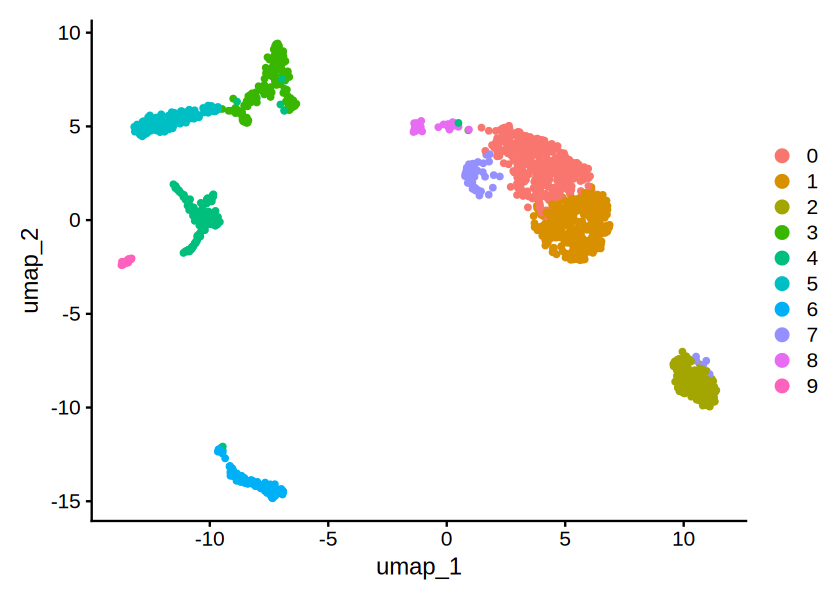

In [27]:
# Visualize UMAP results
DimPlot(seurat_obj, reduction = "umap")

### tSNE

In [28]:
# Run t-SNE
seurat_obj <- RunTSNE(seurat_obj, dims = 1:10)

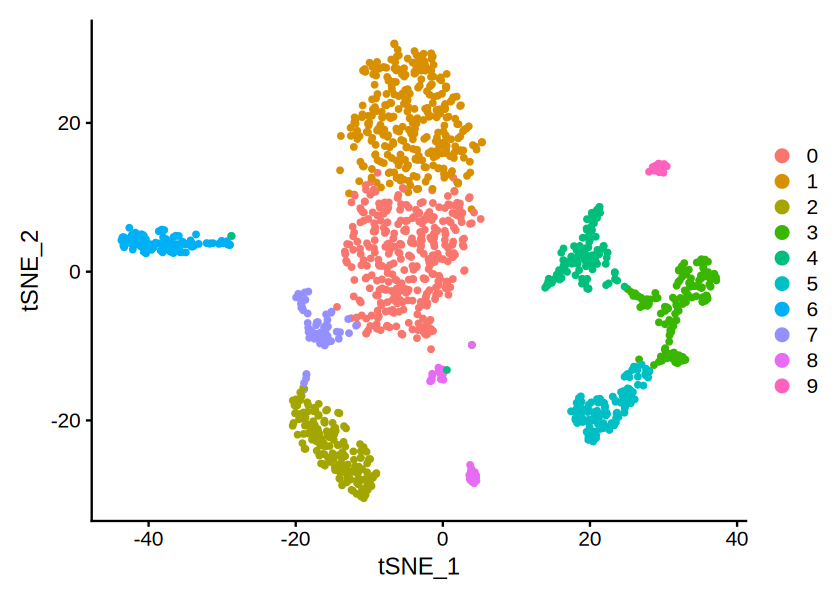

In [29]:
# Visualize t-SNE results
DimPlot(seurat_obj, reduction = "tsne")

In [30]:
# Save the Seurat object
saveRDS(seurat_obj, file = "../data/processed_counts/p1_t1_processed.rds")